In [1]:
# Logger
import logging
logging.basicConfig(level=logging.WARN)

from lcs.metrics import population_metrics
from lcs.agents import EnvironmentAdapter
from lcs import Perception
from lcs.agents.acs2 import ACS2, Configuration, ClassifiersList
from lcs.strategies.action_selection import EpsilonGreedy, ActionDelay, KnowledgeArray

from time import sleep
from copy import copy

import pandas as pd
from matplotlib import pyplot as plt

# Load environments
import gym
import gym_corridor

# Load utils
from utils.corridor import print_cl, plot_performance
from utils.postprocessing import parse_experiments_results

%matplotlib inline

## Parameters
Declaration of parameters that are overwritten by *Papermill*.

In [2]:
corridor_length = 40  # 20/40/100

experiments = 10
explore_trials = 80
exploit_trials = 30

save_figures=False  # save plots to file

In [3]:
ENV_NAME = f'corridor-{corridor_length}-v0'

In [4]:
env = gym.make(ENV_NAME)

# visualization
env.reset()
env.render()

[....................................X..$]


# Metrics

## Knowledge

In [5]:
def all_transitions(grid_size):
    START, END = 1, grid_size
    LEFT, RIGHT = 0, 1
    
    def _handle_state(state):
        moves = []
        if state == START:
            moves.append((state, RIGHT, state+1))
        else:
            moves.append((state, LEFT, state-1))
            moves.append((state, RIGHT, state+1))
        
        return moves
        
    transitions = []
    
    for state in range(START, END):
        transitions += _handle_state(state)
    
    return transitions

transitions = all_transitions(corridor_length)

In [6]:
def calculate_knowledge(population, environment):
    reliable = [c for c in population if c.is_reliable()]
    nr_correct = 0
    
    for start, action, end in transitions:
        p0 = Perception((str(start),))
        p1 = Perception((str(end),))
        
        if any([True for cl in reliable if cl.predicts_successfully(p0, action, p1)]):
            nr_correct += 1
    
    return nr_correct / len(transitions) * 100.0

# Experiments

In [7]:
# Build agent configuration
# Collect additional population metrics
def corridor_metrics(pop, env):
    metrics = {
        'knowledge': calculate_knowledge(pop, env)
    }
    metrics.update(population_metrics(pop, env))
    return metrics

class CorridorAdapter(EnvironmentAdapter):
    @staticmethod
    def to_genotype(phenotype):
        return phenotype,

In [8]:
base_params = {
    "action_selector": EpsilonGreedy,
    "epsilon": 0.8,
    "beta": 0.2,
    "gamma": 0.95,
    "initial_q": 0.5,
    "theta_exp": 50,
    "theta_ga": 50,
    "do_ga": True,
    "mu": 0.03,
    "u_max": 1,
    "metrics_trial_frequency": 2,
    "environment_adapter": CorridorAdapter,
    "user_metrics_collector_fcn": corridor_metrics
}

In [9]:
def start_single_experiment(**kwargs):
    # Prepare the environment
    env.reset()

    cfg = Configuration(1, 2, **kwargs)
    sleep(1)
    
    explorer = ACS2(cfg)
    population_explore, metrics_explore = explorer.explore(env, explore_trials)
    
    exploiter = ACS2(cfg, population_explore)
    population_exploit, metrics_exploit = explorer.exploit(env, exploit_trials)
    
    # Parse results into DataFrame
    df = parse_experiments_results(metrics_explore, metrics_exploit, cfg.metrics_trial_frequency)
    
    return population_exploit, df

In [10]:
def avg_experiments(n, **kwargs):
    dfs = []
    print(f"{kwargs}\n")

    for i in range(n):
        print(f"Executing experiment {i}")
        _, df = start_single_experiment(**kwargs)
        dfs.append(df)
    
    bar = pd.concat(dfs)
    perf_df = bar.groupby(['trial', 'phase']).mean().reset_index(level='phase')

    return perf_df

## Baseline (epsilon greedy)

In [11]:
# Prepare parameters
epsilon_greedy_params = copy(base_params)

epsilon_greedy_df = avg_experiments(experiments, **epsilon_greedy_params)

{'action_selector': <class 'lcs.strategies.action_selection.EpsilonGreedy.EpsilonGreedy'>, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 1, 'metrics_trial_frequency': 2, 'environment_adapter': <class '__main__.CorridorAdapter'>, 'user_metrics_collector_fcn': <function corridor_metrics at 0x11be04710>}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4
Executing experiment 5
Executing experiment 6
Executing experiment 7
Executing experiment 8
Executing experiment 9


## Action Delay Bias

In [12]:
action_delay_params = copy(base_params)
action_delay_params['biased_exploration_prob'] = 0.5
action_delay_params['action_selector'] = ActionDelay

action_delay_df = avg_experiments(experiments, **action_delay_params)

{'action_selector': <class 'lcs.strategies.action_selection.ActionDelay.ActionDelay'>, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 1, 'metrics_trial_frequency': 2, 'environment_adapter': <class '__main__.CorridorAdapter'>, 'user_metrics_collector_fcn': <function corridor_metrics at 0x11be04710>, 'biased_exploration_prob': 0.5}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4
Executing experiment 5
Executing experiment 6
Executing experiment 7
Executing experiment 8
Executing experiment 9


## Knowledge Array Bias

In [13]:
knowledge_array_params = copy(base_params)
knowledge_array_params['biased_exploration_prob'] = 0.5
knowledge_array_params['action_selector'] = KnowledgeArray

knowledge_array_df = avg_experiments(experiments, **knowledge_array_params)

{'action_selector': <class 'lcs.strategies.action_selection.KnowledgeArray.KnowledgeArray'>, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 1, 'metrics_trial_frequency': 2, 'environment_adapter': <class '__main__.CorridorAdapter'>, 'user_metrics_collector_fcn': <function corridor_metrics at 0x11be04710>, 'biased_exploration_prob': 0.5}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4
Executing experiment 5
Executing experiment 6
Executing experiment 7
Executing experiment 8
Executing experiment 9


## Optimistic initial quality values

In [14]:
op_initial_params = copy(base_params)
op_initial_params['initial_q'] = 0.8

op_initial_df = avg_experiments(experiments, **op_initial_params)

{'action_selector': <class 'lcs.strategies.action_selection.EpsilonGreedy.EpsilonGreedy'>, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.8, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 1, 'metrics_trial_frequency': 2, 'environment_adapter': <class '__main__.CorridorAdapter'>, 'user_metrics_collector_fcn': <function corridor_metrics at 0x11be04710>}

Executing experiment 0
Executing experiment 1
Executing experiment 2
Executing experiment 3
Executing experiment 4
Executing experiment 5
Executing experiment 6
Executing experiment 7
Executing experiment 8
Executing experiment 9


# Visualization

## Knowledge (latent-learning)

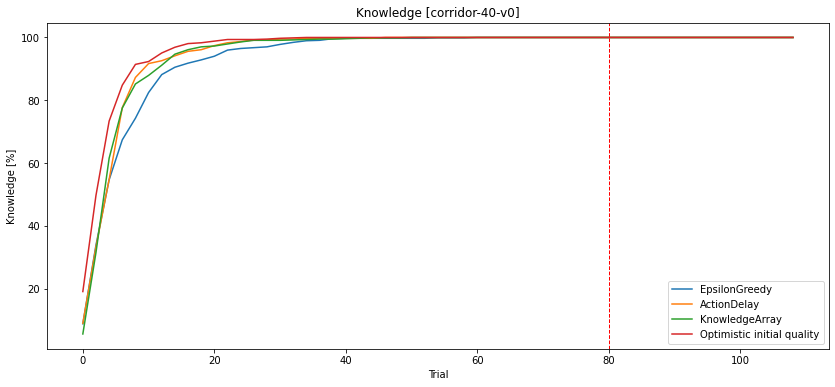

In [15]:
fig, ax = plt.subplots(1,1, figsize=(14, 6))

epsilon_greedy_df['knowledge'].plot(label=epsilon_greedy_params['action_selector'].__name__, ax=ax)
action_delay_df['knowledge'].plot(label=action_delay_params['action_selector'].__name__, ax=ax)
knowledge_array_df['knowledge'].plot(label=knowledge_array_params['action_selector'].__name__, ax=ax)
op_initial_df['knowledge'].plot(label='Optimistic initial quality', ax=ax)


ax.axvline(x=explore_trials, color='red', linewidth=1, linestyle="--")

ax.set_xlabel('Trial')
ax.set_ylabel('Knowledge [%]')
ax.set_title(f'Knowledge [{env.unwrapped.spec.id}]')
ax.legend()

plt.show()

## Steps to goal (reinforcement-learning)

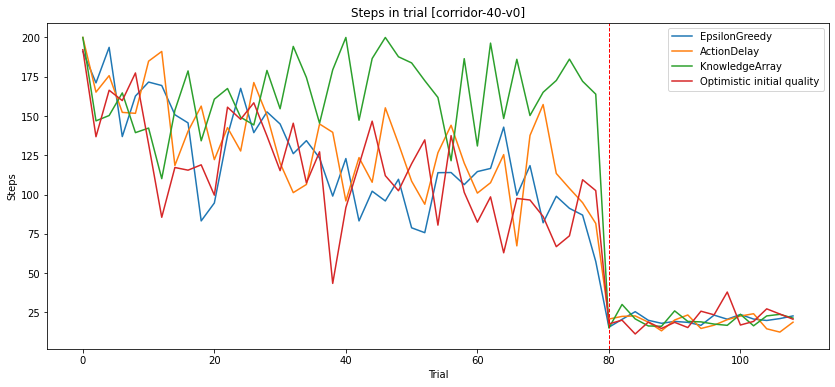

In [16]:
fig, ax = plt.subplots(1,1, figsize=(14, 6))

epsilon_greedy_df['steps_in_trial'].plot(label=epsilon_greedy_params['action_selector'].__name__, ax=ax)
action_delay_df['steps_in_trial'].plot(label=action_delay_params['action_selector'].__name__, ax=ax)
knowledge_array_df['steps_in_trial'].plot(label=knowledge_array_params['action_selector'].__name__, ax=ax)
op_initial_df['steps_in_trial'].plot(label='Optimistic initial quality', ax=ax)

ax.axvline(x=explore_trials, color='red', linewidth=1, linestyle="--")

ax.set_xlabel('Trial')
ax.set_ylabel('Steps')
ax.set_title(f'Steps in trial [{env.unwrapped.spec.id}]')
ax.legend()

plt.show()

if save_figures:
    fig.savefig('corridor-steps-in-trial.pdf')

## Population count

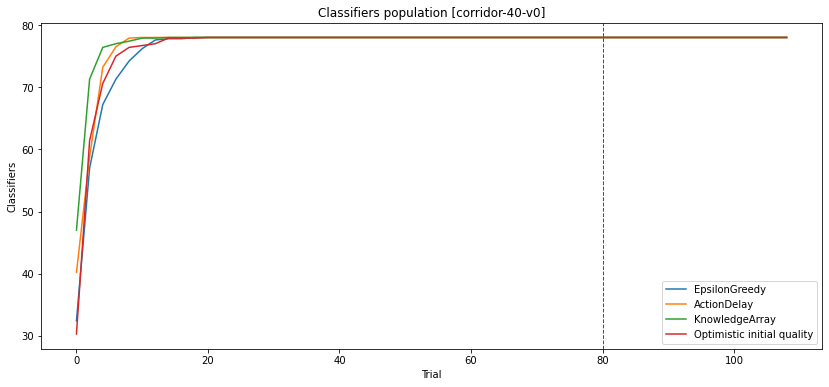

In [17]:
fig, ax = plt.subplots(1,1, figsize=(14, 6))

epsilon_greedy_df['population'].plot(label=epsilon_greedy_params['action_selector'].__name__, ax=ax)
action_delay_df['population'].plot(label=action_delay_params['action_selector'].__name__, ax=ax)
knowledge_array_df['population'].plot(label=knowledge_array_params['action_selector'].__name__, ax=ax)
op_initial_df['population'].plot(label='Optimistic initial quality', ax=ax)


ax.axvline(x=explore_trials, color='red', linewidth=1, linestyle="--")

ax.set_xlabel('Trial')
ax.set_ylabel('Classifiers')
ax.set_title(f'Classifiers population [{env.unwrapped.spec.id}]')
ax.legend()

plt.show()

if save_figures:
    fig.savefig('corridor-population-count.pdf')